# Gradient damage as phase-field models of brittle fracture: dolfinx example

*Authors: Jack Hale, Corrado Maurini, 2021*

In this notebook we implement a numerical solution of the quasi-static evolution problem for gradient damage models, and show how they can be used to solve brittle fracture problems.

Denoting by $u$ the displacement field (vector valued) and by $\alpha$ the scalar damage field we consider the energy functional

$$
\mathcal{E}_{\ell}(u, \alpha)=
\dfrac{1}{2}\int_{\Omega} a({\alpha})
A_0\,\epsilon(u)\cdot\epsilon(u)\,dx
+
 \,
\dfrac{G_c}{c_w} \int_{\Omega}\left(
\dfrac{w(\alpha)}{\ell}+
{\ell}\,\nabla {\alpha}\cdot\nabla{\alpha}\right)dx,
$$

where $\epsilon(u)$ is the strain tensor, $\sigma_0=A_0\,\epsilon=\lambda \mathrm{tr}\epsilon+2\mu \epsilon$ the stress of the undamaged material, $a({\alpha})$  the stiffness modulation function though the damage field, $w_1\,w(\alpha)$ the energy dissipation in an homogeouns process and $\ell$ the internal length.

In the following we will solve, at each time step $t_i$ the minimization problem 

$$
\min\mathcal{E}_{\ell}(u, \alpha),\quad u\in\mathcal{C}_i, \alpha\in \mathcal{D}_i,
$$

where $\mathcal{C}_i$ is the space of kinematically admissible displacement at 
time $t_i$ and $\mathcal{D}_i$ the admissible damage fields, that should respect the irreversibility conditions 
$\alpha\geq\alpha_{i-1}$. 

Here we will
 * Discretize the problme using $P_1$ finite elements for the displacement and the damage field
 * Use alternate minimization to solve the minimization problem at each time step
 * Use PETSc solver to solve linear problems and variational inequality at discrete level
 

We will consider here the specific problem of the **traction of a two-dimensional bar in plane-stress**, where
$
\Omega =[0,L]\times[0,H]
$ and the loading is given by 
under imposed end-displacement $u=(t,0)$ in $x=L$, the left-end being clamped : $u=(0,0)$ in $x=0$. 

You can find further informations about this model here:
- Marigo, J.-J., Maurini, C., & Pham, K. (2016). An overview of the modelling of fracture by gradient damage models. Meccanica, 1–22. https://doi.org/10.1007/s11012-016-0538-4 

## Preamble 

Here we import the required Python modules and set few parameters.

The FEniCS container does not have the `sympy` module by default so we install it using pip.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import dolfinx
from dolfinx import mesh, fem, plot, io, la
import ufl

from mpi4py import MPI
from petsc4py import PETSc

import pyvista
from pyvista.utilities.xvfb import start_xvfb
start_xvfb(wait=0.5)

import sys
sys.path.append("../utils/")
#from snes_problem import SNESProblem

from plots import plot_damage_state
pyvista.set_jupyter_backend("none")

## Mesh 

We define here the mesh and the indicators for the boundary conditions. The function `generate_mesh` uses `gmsh` (https://gmsh.info/).

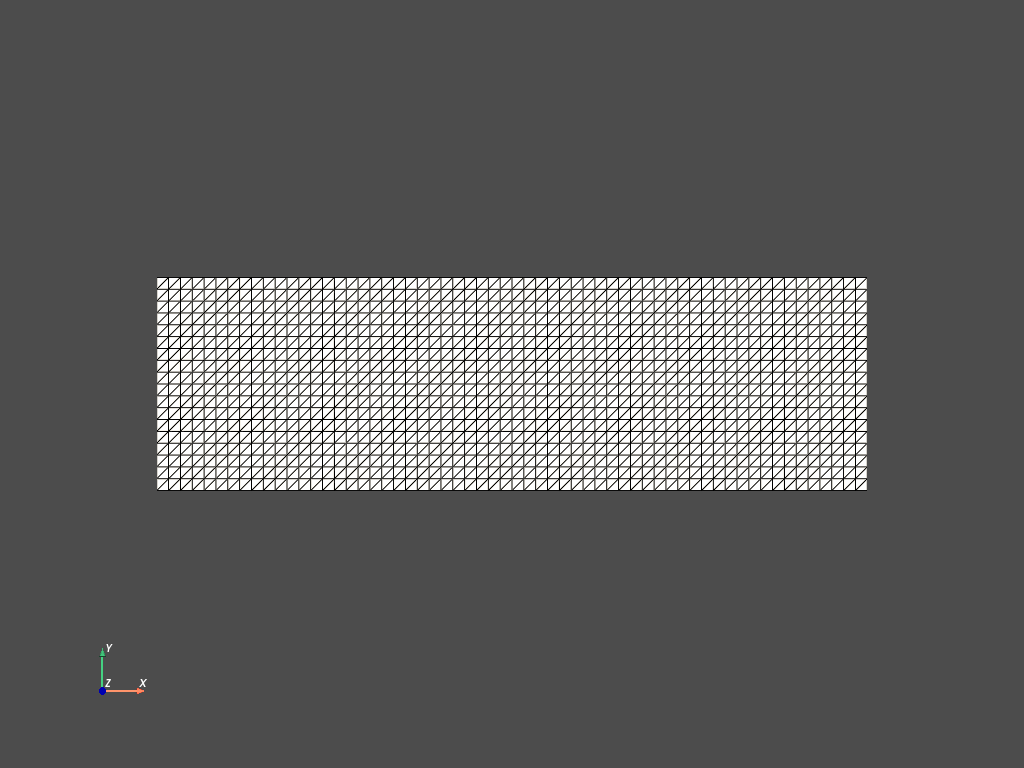

In [2]:
L = 1.; H = 0.3
ell_ = 0.1
cell_size = ell_/6

nx = int(L/cell_size)
ny = int(H/cell_size)

comm = MPI.COMM_WORLD
domain = mesh.create_rectangle(comm, [(0.0, 0.0), (L, H)], [nx, ny])
ndim = domain.geometry.dim


pyvista.OFF_SCREEN = False
topology, cell_types, geometry = plot.create_vtk_mesh(domain)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True, show_scalar_bar=True)
plotter.view_xy()
plotter.add_axes()
plotter.set_scale(5,5)
#plotter.reset_camera(render=True, bounds=(-L/2, L/2, -H/2, H/2, 0, 0))
if not pyvista.OFF_SCREEN:
    plotter.show()

from pathlib import Path
Path("output").mkdir(parents=True, exist_ok=True)
#figure = plotter.screenshot("output/mesh.png")



## Setting the stage

Setting the finite element space, the state vector, test/trial functions and measures.

We use $P_1$ finite element (triangle with linear Lagrange polynomial as shape functions and nodal values as dofs) for both displacement and damage. 

In [3]:
element_u = ufl.VectorElement('Lagrange',domain.ufl_cell(),degree=1,dim=2)
V_u = fem.FunctionSpace(domain, element_u)

element_alpha = ufl.FiniteElement('Lagrange',domain.ufl_cell(),degree=1)
V_alpha = fem.FunctionSpace(domain, element_alpha)

# Define the state
u = fem.Function(V_u, name="Displacement")
alpha = fem.Function(V_alpha, name="Damage")

state = {"u": u, "alpha": alpha}

# need upper/lower bound for the damage field
alpha_lb = fem.Function(V_alpha, name="Lower bound")
alpha_ub = fem.Function(V_alpha, name="Upper bound")
alpha_ub.x.array[:] = 1
alpha_lb.x.array[:] = 0

# Measures
dx = ufl.Measure("dx",domain=domain)
ds = ufl.Measure("ds",domain=domain)

### Boundary conditions
We impose the boundary conditions on the displacement and the damage field. 

In [4]:
def bottom(x):
    return np.isclose(x[1], 0.0)

def top(x):
    return np.isclose(x[1], H)

def right(x):
    return np.isclose(x[0], L)

def left(x):
    return np.isclose(x[0], 0.0)

fdim = domain.topology.dim-1

left_facets = mesh.locate_entities_boundary(domain, fdim, left)
right_facets = mesh.locate_entities_boundary(domain, fdim, right)
bottom_facets = mesh.locate_entities_boundary(domain, fdim, bottom)
top_facets = mesh.locate_entities_boundary(domain, fdim, top)
left_boundary_dofs_ux = fem.locate_dofs_topological(V_u.sub(0), fdim, left_facets)
right_boundary_dofs_ux = fem.locate_dofs_topological(V_u.sub(0), fdim, right_facets)
bottom_boundary_dofs_uy = fem.locate_dofs_topological(V_u.sub(1), fdim, bottom_facets)
top_boundary_dofs_uy = fem.locate_dofs_topological(V_u.sub(1), fdim, top_facets)


u_D = fem.Constant(domain,PETSc.ScalarType(1.))
bc_u_left = fem.dirichletbc(0.0, left_boundary_dofs_ux, V_u.sub(0))
bc_u_right = fem.dirichletbc(u_D, right_boundary_dofs_ux, V_u.sub(0))
bc_u_bottom = fem.dirichletbc(0.0, bottom_boundary_dofs_uy, V_u.sub(1))
bc_u_top = fem.dirichletbc(0.0, top_boundary_dofs_uy, V_u.sub(1))
bcs_u = [bc_u_left,bc_u_right,bc_u_bottom]

left_boundary_dofs_alpha = fem.locate_dofs_topological(V_alpha, fdim, left_facets)
right_boundary_dofs_alpha = fem.locate_dofs_topological(V_alpha, fdim, right_facets)
bc_alpha_left = fem.dirichletbc(0.0, left_boundary_dofs_alpha, V_alpha)
bc_alpha_right = fem.dirichletbc(0.0, right_boundary_dofs_alpha, V_alpha)

bcs_alpha = [bc_alpha_left,bc_alpha_right]

## Variational formulation of the problem

### Constitutive functions

We define here the constitutive functions and the related parameters. 
These functions will be used to define the energy. You can try to change them, the code is sufficiently generic to allows for a wide class of function $w$ and $a$.

**Exercice:** Show by dimensional analysis that varying $G_c$ and $E$ is equivalent to a rescaling of the displacement by a factor 

$$
u_0 = \sqrt{\frac{G_c L}{E}}
$$

We can then choose these constants freely in the numerical work and simply rescale the displacement to match the material data of a specific brittle material. 
The *real* material parameters (in the sense that they are those that affect the results) are   
- the Poisson ratio $\nu$ and 
- the ratio $\ell/L$ between internal length $\ell$ and the domain size $L$. 

In [5]:
E, nu = fem.Constant(domain, PETSc.ScalarType(100.0)), fem.Constant(domain, PETSc.ScalarType(0.3))
Gc = fem.Constant(domain, PETSc.ScalarType(1.0))
ell = fem.Constant(domain, PETSc.ScalarType(ell_))

def w(alpha):
    """Dissipated energy function as a function of the damage """
    return alpha

def a(alpha, k_ell=1.e-6):
    """Stiffness modulation as a function of the damage """
    return (1 - alpha) ** 2 + k_ell

def eps(u):
    """Strain tensor as a function of the displacement"""
    return ufl.sym(ufl.grad(u))

def sigma_0(u):
    """Stress tensor of the undamaged material as a function of the displacement"""
    mu    = E / (2.0 * (1.0 + nu))
    lmbda = E * nu / (1.0 - nu ** 2)
    return 2.0 * mu * eps(u) + lmbda * ufl.tr(eps(u)) * ufl.Identity(ndim)

def sigma(u,alpha):
    """Stress tensor of the damaged material as a function of the displacement and the damage"""
    return a(alpha) * sigma_0(u)


**Exercise:** Show that 
1. One can relate the dissipation constant $w_1$ to the energy dissipated in a smeared representation of a crack through the following relation:
\begin{equation}
{G_c}={c_w}\,w_1\ell,\qquad c_w =4\int_0^1\sqrt{w(\alpha)}d\alpha
\end{equation}
2. The half-width of a localisation zone is given by:
$$
D =  c_{1/w} \ell,\qquad c_{1/w}=\int_0^1 \frac{1}{\sqrt{w(\alpha)}}d\alpha
$$
3. The elastic limit of the material is:
$$
\sigma_c = \sqrt{w_1\,E_0}\sqrt{\dfrac{2w'(0)}{s'(0)}}= \sqrt{\dfrac{G_cE_0}{\ell c_w}}
\sqrt{\dfrac{2w'(0)}{s'(0)}}
$$
*Hint:* Calculate the damage profile and the energy of a localised solution with vanishing stress in a 1d traction problem

For the function above we get (we perform the integral with `sympy`).

In [6]:
import sympy 
z = sympy.Symbol("z")
c_w = 4*sympy.integrate(sympy.sqrt(w(z)),(z,0,1))
print("c_w = ",c_w)

c_1w = sympy.integrate(sympy.sqrt(1/w(z)),(z,0,1))
print("c_1/w = ",c_1w)

tmp = 2*(sympy.diff(w(z),z)/sympy.diff(1/a(z),z)).subs({"z":0})
sigma_c = sympy.sqrt(tmp * Gc.value * E.value / (c_w * ell.value))
print("sigma_c = %2.3f"%sigma_c)

eps_c = float(sigma_c/E.value)
print("eps_c = %2.3f"%eps_c)

c_w =  8/3
c_1/w =  2
sigma_c = 19.365
eps_c = 0.194


### Energy functional and its derivatives

We use the `UFL` 
 component of FEniCS to define the energy functional.
Directional derivatives of the energy are computed using symbolic computation functionalities of `UFL`, see http://fenics-ufl.readthedocs.io/en/latest/

In [7]:
f = fem.Constant(domain,PETSc.ScalarType((0.,0.)))
elastic_energy = 0.5 * ufl.inner(sigma(u,alpha), eps(u)) * dx 
dissipated_energy = Gc / float(c_w) * (w(alpha) / ell + ell * ufl.dot(ufl.grad(alpha), ufl.grad(alpha))) * dx
external_work = ufl.dot(f, u) * dx 
total_energy = elastic_energy + dissipated_energy - external_work

## Solvers

In [8]:
class NonlinearPDE_SNESProblem:
    def __init__(self, F, u, bcs, J=None):
        V = u.function_space
        du = ufl.TrialFunction(V)
        self.L = fem.form(F)
        if J is None:
            self.a = fem.form(ufl.derivative(F, u, du))
        else:
            self.a = fem.form(J)
        self.bcs = bcs
        self._F, self._J = None, None
        self.u = u

    def F(self, snes, x, F):
        """Assemble residual vector."""
        x.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
        x.copy(self.u.vector)
        self.u.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

        with F.localForm() as f_local:
            f_local.set(0.0)
        fem.petsc.assemble_vector(F, self.L)
        fem.petsc.apply_lifting(F, [self.a], bcs=[self.bcs], x0=[x], scale=-1.0)
        F.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        fem.petsc.set_bc(F, self.bcs, x, -1.0)

    def J(self, snes, x, J, P):
        """Assemble Jacobian matrix."""
        J.zeroEntries()
        fem.petsc.assemble_matrix(J, self.a, bcs=self.bcs)
        J.assemble()


### Displacement problem
The $u$-problem at fixed $\alpha$ is a linear problem corresponding with linear elasticity. We solve it with a standard linear solver. We use automatic differention to get the first derivative of the energy. We use a direct solve to solve the linear system, but you can also easily set iterative solvers and preconditioners when solving large problem in parallel.

In [9]:
E_u = ufl.derivative(total_energy,u,ufl.TestFunction(V_u))
E_u_u = ufl.derivative(E_u,u,ufl.TrialFunction(V_u))
elastic_problem = NonlinearPDE_SNESProblem(E_u, u, bcs_u)

In [10]:
#E_u = ufl.derivative(total_energy,u,ufl.TestFunction(V_u))
#E_du = ufl.replace(E_u,{u: ufl.TrialFunction(V_u)})
#problem_u = fem.petsc.LinearProblem(a=E_du, L=E_u, bcs=bcs_u, u=u,petsc_options={"ksp_type": "preonly", "pc_type": "lu"})

b_u = la.create_petsc_vector(V_u.dofmap.index_map, V_u.dofmap.index_map_bs)
J_u = fem.petsc.create_matrix(elastic_problem.a)
# Create Newton solver and solve
solver_u_snes = PETSc.SNES().create()
solver_u_snes.setType("ksponly")
solver_u_snes.setFunction(elastic_problem.F, b_u)
solver_u_snes.setJacobian(elastic_problem.J, J_u)
solver_u_snes.setTolerances(rtol=1.0e-9, max_it=50)
solver_u_snes.getKSP().setType("preonly")
solver_u_snes.getKSP().setTolerances(rtol=1.0e-9)
solver_u_snes.getKSP().getPC().setType("lu")

We test below the solution of the elasticity problem

  warnings.warn(



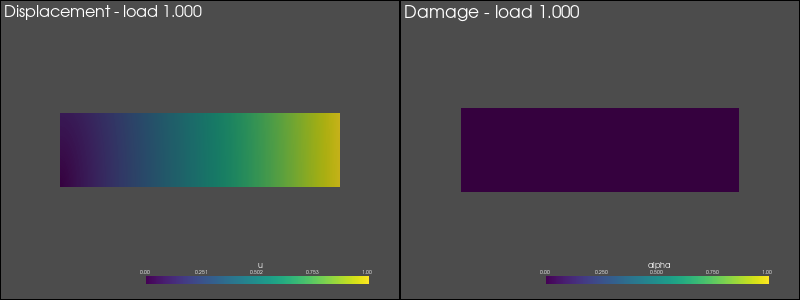

In [11]:

def plot_damage_state(state, load=None):
    """
    Plot the displacement and damage field with pyvista
    """
    u = state["u"]
    alpha = state["alpha"]

    mesh = u.function_space.mesh

    plotter = pyvista.Plotter(
        title="Damage state", window_size=[800, 300], shape=(1, 2)
    )

    topology, cell_types, x = plot.create_vtk_mesh(domain)
    grid = pyvista.UnstructuredGrid(topology, cell_types, x)
    
    plotter.subplot(0, 0)
    if load is not None:
        plotter.add_text(f"Displacement - load {load:3.3f}", font_size=11)
    else:
        plotter.add_text("Displacement", font_size=11)
    vals = np.zeros((x.shape[0], 3))
    vals[:,:len(u)] = u.x.array.reshape((x.shape[0], len(u)))
    grid["u"] = vals
    warped = grid.warp_by_vector("u", factor=0.1)
    actor_1 = plotter.add_mesh(warped, show_edges=False)
    plotter.view_xy()

    plotter.subplot(0, 1)
    if load is not None:
        plotter.add_text(f"Damage - load {load:3.3f}", font_size=11)
    else:
        plotter.add_text("Damage", font_size=11)
    grid.point_arrays["alpha"] = alpha.x.array
    grid.set_active_scalars("alpha")
    plotter.add_mesh(grid, show_edges=False, show_scalar_bar=True, clim=[0, 1])
    plotter.view_xy()
    if not pyvista.OFF_SCREEN:
        plotter.show()
        
load = 1.
u_D.value = load
u.x.array[:] = 0
solver_u_snes.solve(None, u.vector)
plot_damage_state(state,load=load)

### Damage problem with bound-constraints

The $\alpha$-problem at fixed $u$ is a variational inequality, because of the irreversibility constraint. We solve it using a specific solver for bound-constrained provided by `PETSC`, called `SNESVI`. To this end we define with a specific syntax a class defining the problem, and the lower (`lb`) and upper (`ub`) bounds. 

See the [../03-variational-inequalities/VI.ipynb](../03-variational-inequalities/VI.ipynb) notebook for further details

We now set up the PETSc solver using petsc4py (https://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/SNES/SNESVINEWTONRSLS.html)

In [12]:
E_alpha = ufl.derivative(total_energy,alpha,ufl.TestFunction(V_alpha))
E_alpha_alpha = ufl.derivative(E_alpha,alpha,ufl.TrialFunction(V_alpha))
damage_problem = NonlinearPDE_SNESProblem(E_alpha, alpha, bcs_alpha,J=E_alpha_alpha)

In [13]:

b_alpha = la.create_petsc_vector(V_alpha.dofmap.index_map, V_alpha.dofmap.index_map_bs)
J_alpha = fem.petsc.create_matrix(damage_problem.a)
# Create Newton solver and solve
solver_alpha_snes = PETSc.SNES().create()
solver_alpha_snes.setType("vinewtonrsls")
solver_alpha_snes.setFunction(damage_problem.F, b_alpha)
solver_alpha_snes.setJacobian(damage_problem.J, J_alpha)
solver_alpha_snes.setTolerances(rtol=1.0e-9, max_it=50)
solver_alpha_snes.getKSP().setType("preonly")
solver_alpha_snes.getKSP().setTolerances(rtol=1.0e-9)
solver_alpha_snes.getKSP().getPC().setType("lu")
# We set the bound (Note: they are passed as reference and not as values)
solver_alpha_snes.setVariableBounds(alpha_lb.vector,alpha_ub.vector)

Let us known test the damage solver

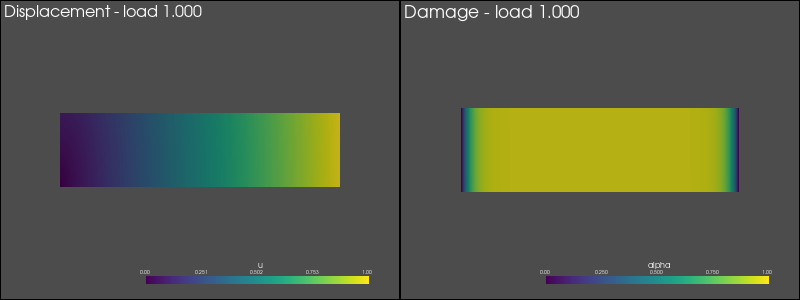

In [14]:
solver_alpha_snes.solve(None, alpha.vector)
plot_damage_state(state,load=load)

### The static problem: solution with the alternate minimization algorithm

We solve the nonlinear problem in $(u,\alpha)$ at each time-step by a fixed-point algorithm consisting in alternate minimization with respect to $u$ at fixed $\alpha$ and viceversa, *i.e.* we solve till convergence the $u$- and the $\alpha$-problems above.

The main idea is to iterate as following solution of displacement and damage subproblem at fixed loading

iteration 0


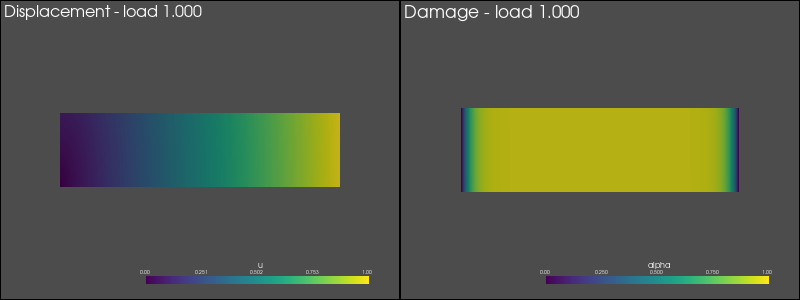

iteration 1


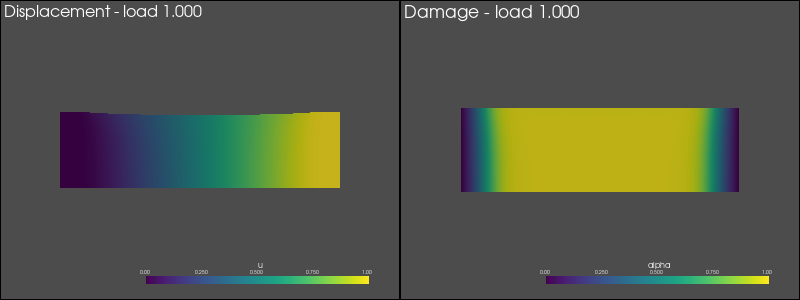

iteration 2


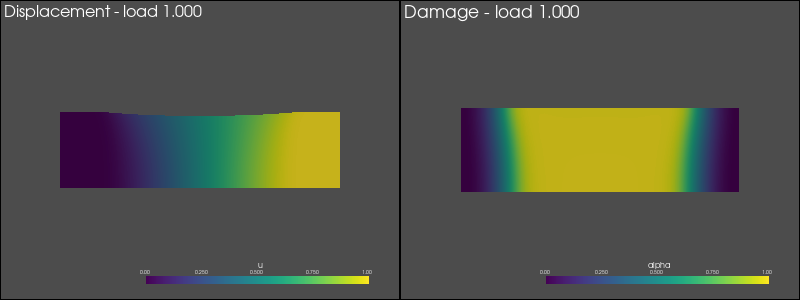

iteration 3


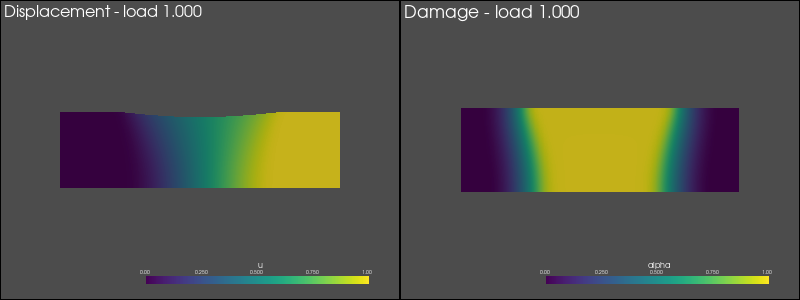

iteration 4


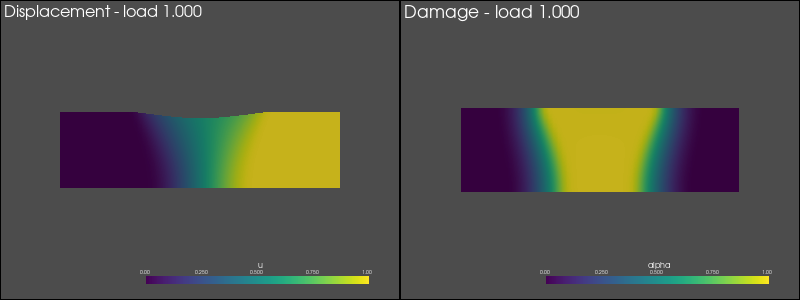

iteration 5


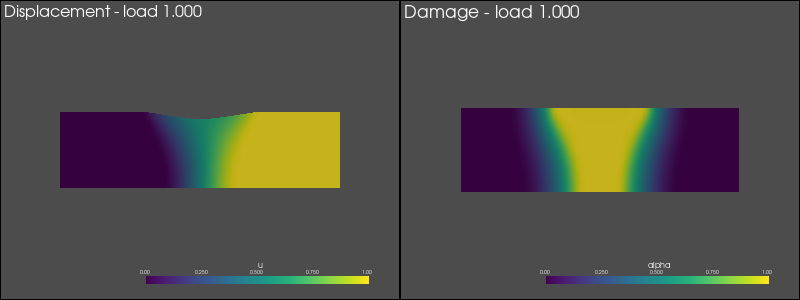

iteration 6


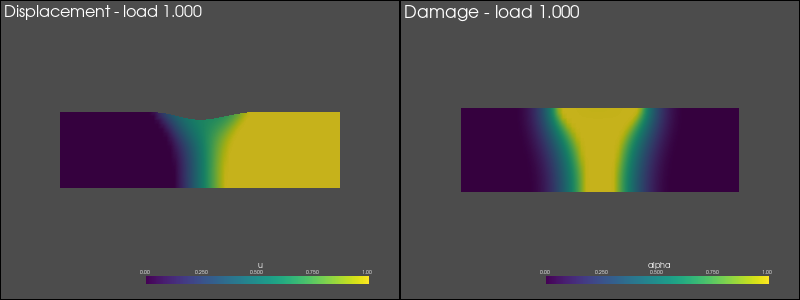

iteration 7


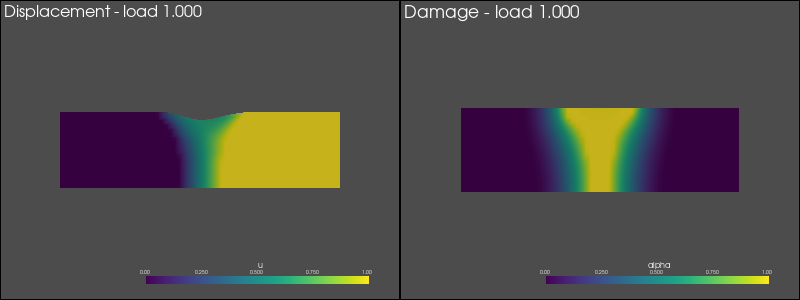

iteration 8


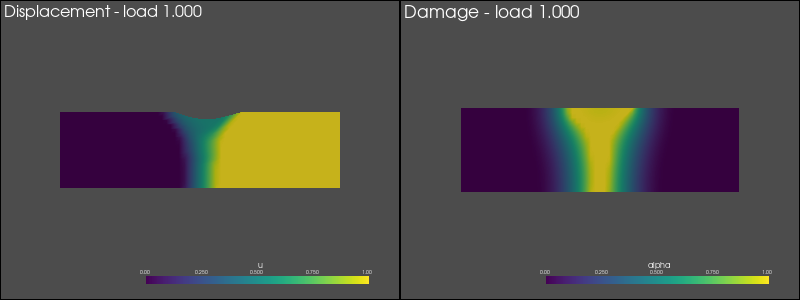

iteration 9


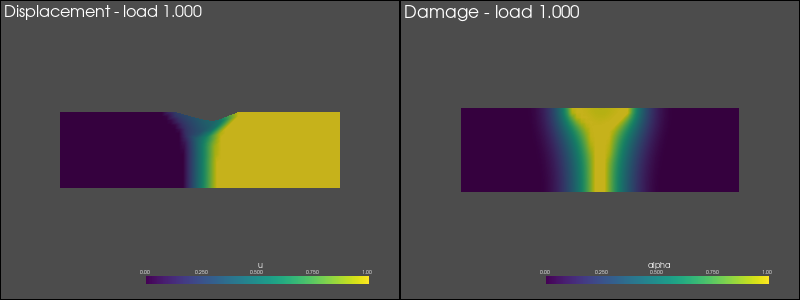

In [15]:
with alpha.vector.localForm() as alpha_local:
    alpha_local.set(0)

for i in range(10):
    print(f"iteration {i}")
    solver_u_snes.solve(None, u.vector)
    solver_alpha_snes.solve(None, alpha.vector)
    plot_damage_state(state,load)

We need to add a convergence condition for the fixed point algorithm.
We define it the following function

In [16]:
alt_min_parameters = {"atol": 1.e-8, "max_iter": 100}

def simple_monitor(state, iteration, error_L2):
    #if MPI.comm_world.rank == 0:
    print(f"Iteration: {iteration:3d}, Error: {error_L2:3.4e}")
    
def alternate_minimization(state,parameters=alt_min_parameters,monitor=None):
    
    u = state["u"]
    alpha = state["alpha"]
    
    alpha_old = fem.Function(alpha.function_space)
    alpha.vector.copy(result=alpha_old.vector)
    
    for iteration in range(parameters["max_iter"]):
                              
        # solve displacement
        solver_u_snes.solve(None, u.vector)
        
        # solve damage
        solver_alpha_snes.solve(None, alpha.vector)
        
        # check error and update
        L2_error = ufl.inner(alpha - alpha_old, alpha - alpha_old) * dx
        error_L2 = np.sqrt(fem.assemble_scalar(fem.form(L2_error)))
        alpha.vector.copy(alpha_old.vector)
        
        if monitor is not None:
            monitor(state, iteration, error_L2)
                                 
        if error_L2 <= parameters["atol"]:
            break
    else:
        pass #raise RuntimeError(f"Could not converge after {iteration:3d} iteration, error {error_L2:3.4e}") 
    
    return (error_L2, iteration)

We can test it by solving the problem at fixed problem. We need to reset to zeror the damage field to start

Iteration:   0, Error: 5.0495e-01
Iteration:   1, Error: 1.0806e-01
Iteration:   2, Error: 1.2095e-01
Iteration:   3, Error: 1.1832e-01
Iteration:   4, Error: 1.0280e-01
Iteration:   5, Error: 8.1148e-02
Iteration:   6, Error: 5.3847e-02
Iteration:   7, Error: 3.4771e-02
Iteration:   8, Error: 2.1697e-02
Iteration:   9, Error: 1.9476e-02
Iteration:  10, Error: 2.1205e-02
Iteration:  11, Error: 3.6674e-02
Iteration:  12, Error: 5.1267e-03
Iteration:  13, Error: 6.4989e-03
Iteration:  14, Error: 6.7068e-03
Iteration:  15, Error: 3.5385e-03
Iteration:  16, Error: 1.0850e-03
Iteration:  17, Error: 1.6868e-05
Iteration:  18, Error: 4.9398e-05
Iteration:  19, Error: 3.0402e-04
Iteration:  20, Error: 1.6020e-03
Iteration:  21, Error: 8.6358e-05
Iteration:  22, Error: 3.3019e-08
Iteration:  23, Error: 2.2678e-11


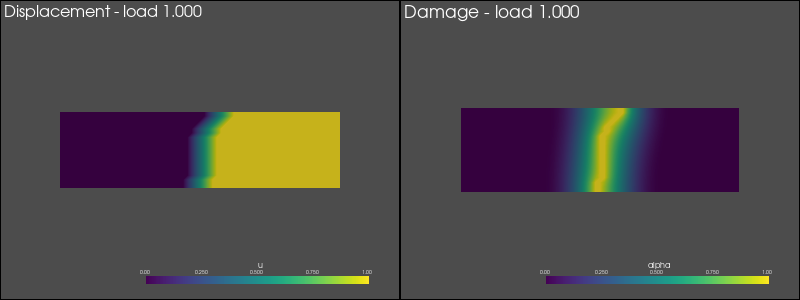

In [17]:
alpha.x.array[:] = 0
    
alternate_minimization(state,parameters=alt_min_parameters,monitor=simple_monitor)
plot_damage_state(state, load=load)

## Time-stepping: solving a quasi-static problem

In [18]:
def postprocessing(state, iteration, error_L2):
    
    # Save number of iterations for the time step
    iterations[i_t] = np.array([t,i_t])
    
    # Calculate the energies
    elastic_energy_value = comm.allreduce(
            dolfinx.fem.assemble_scalar(dolfinx.fem.form(elastic_energy)),
            op=MPI.SUM,
        )
    surface_energy_value = comm.allreduce(dolfinx.fem.assemble_scalar(dolfinx.fem.form(dissipated_energy)),
            op=MPI.SUM,
        )
    energies[i_t] = np.array([t,elastic_energy_value,surface_energy_value,elastic_energy_value+surface_energy_value])
    
    simple_monitor(state, iteration, error_L2)

-- Solving for t = 0.00 --


INFO:root:running build_ext
INFO:root:building 'libffcx_forms_470c7dd193ad14043db9ec0b918ccf9c73574eac' extension
INFO:root:clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /Users/maurini/anaconda3/envs/solid-mechanics/include -arch arm64 -fPIC -O2 -isystem /Users/maurini/anaconda3/envs/solid-mechanics/include -arch arm64 -I/Users/maurini/anaconda3/envs/solid-mechanics/lib/python3.10/site-packages/ffcx/codegeneration -I/Users/maurini/anaconda3/envs/solid-mechanics/include/python3.10 -c libffcx_forms_470c7dd193ad14043db9ec0b918ccf9c73574eac.c -o ./libffcx_forms_470c7dd193ad14043db9ec0b918ccf9c73574eac.o -O2 -g0
INFO:root:clang -bundle -undefined dynamic_lookup -Wl,-rpath,/Users/maurini/anaconda3/envs/solid-mechanics/lib -L/Users/maurini/anaconda3/envs/solid-mechanics/lib -Wl,-rpath,/Users/maurini/anaconda3/envs/solid-mechanics/lib -L/Users/maurini/anaconda3/envs/solid-mechanics/lib ./libffcx_forms_470c7dd193ad14043db9ec0b918ccf9c73

Iteration:   0, Error: 0.0000e+00


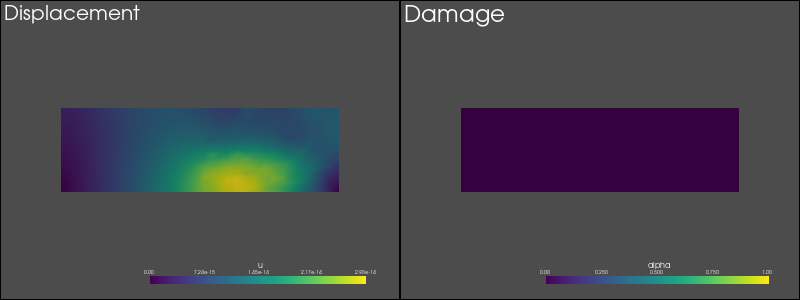

-- Solving for t = 0.02 --
Iteration:   0, Error: 0.0000e+00


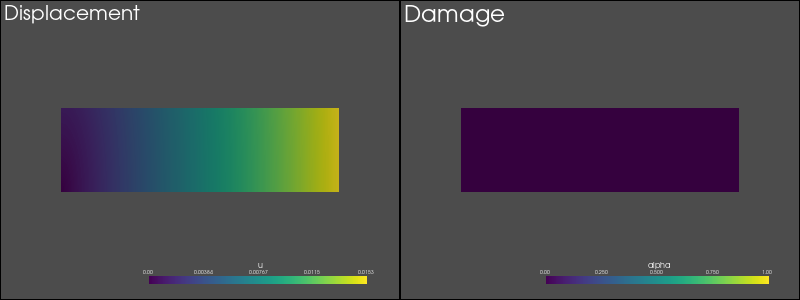

-- Solving for t = 0.03 --
Iteration:   0, Error: 0.0000e+00


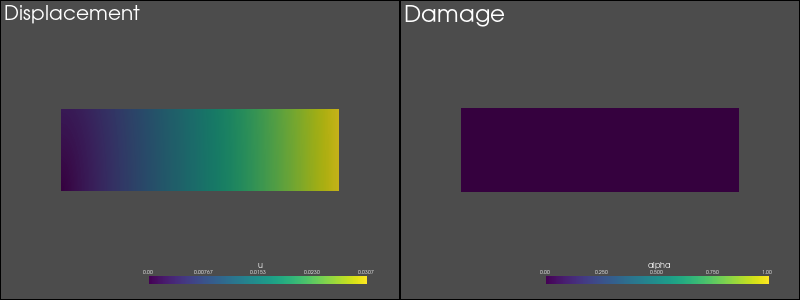

-- Solving for t = 0.05 --
Iteration:   0, Error: 0.0000e+00


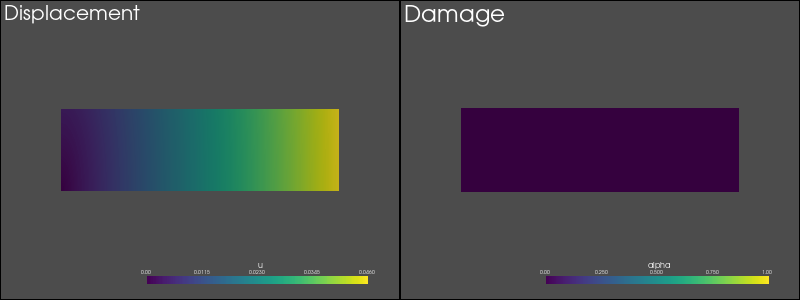

-- Solving for t = 0.06 --
Iteration:   0, Error: 0.0000e+00


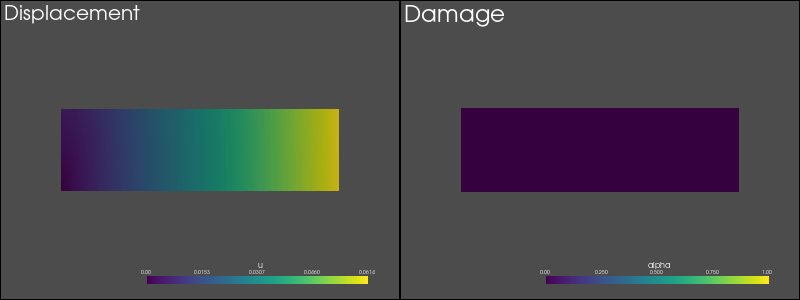

-- Solving for t = 0.08 --
Iteration:   0, Error: 0.0000e+00


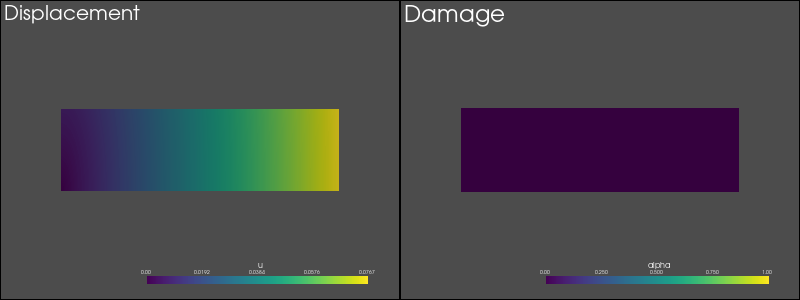

-- Solving for t = 0.09 --
Iteration:   0, Error: 0.0000e+00


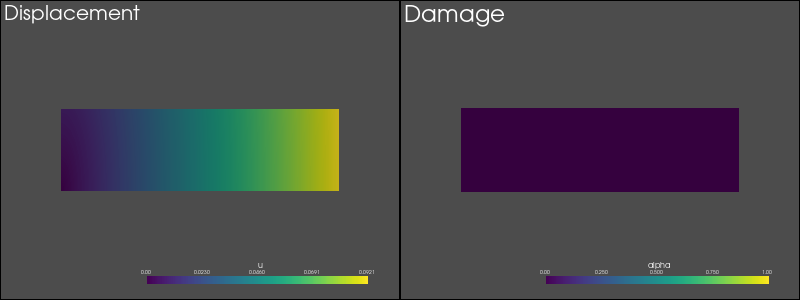

-- Solving for t = 0.11 --
Iteration:   0, Error: 0.0000e+00


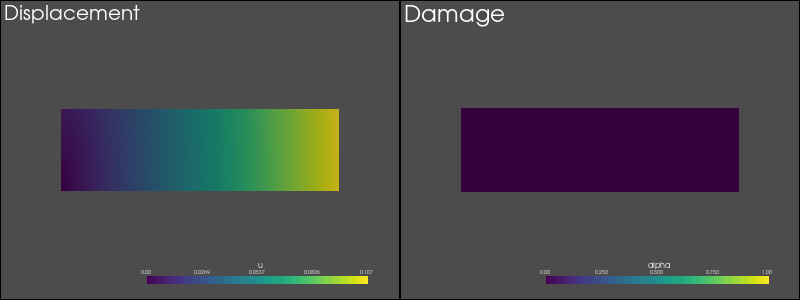

-- Solving for t = 0.12 --
Iteration:   0, Error: 0.0000e+00


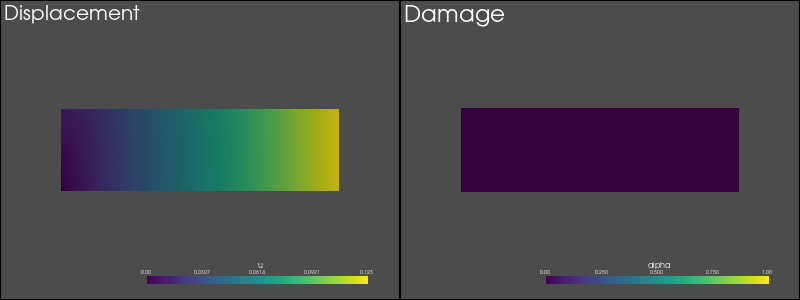

-- Solving for t = 0.14 --
Iteration:   0, Error: 0.0000e+00


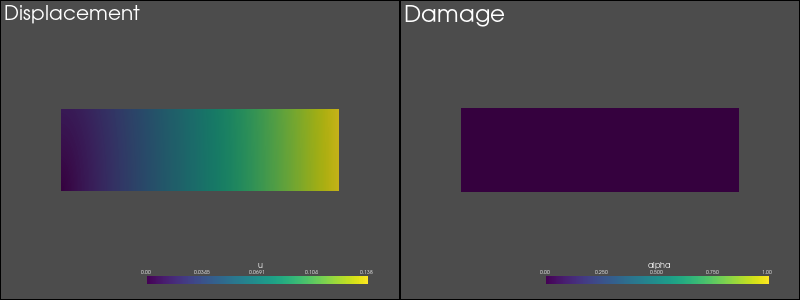

-- Solving for t = 0.15 --
Iteration:   0, Error: 0.0000e+00


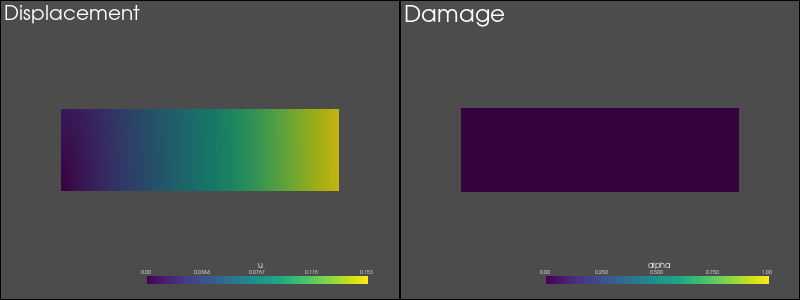

-- Solving for t = 0.17 --
Iteration:   0, Error: 0.0000e+00


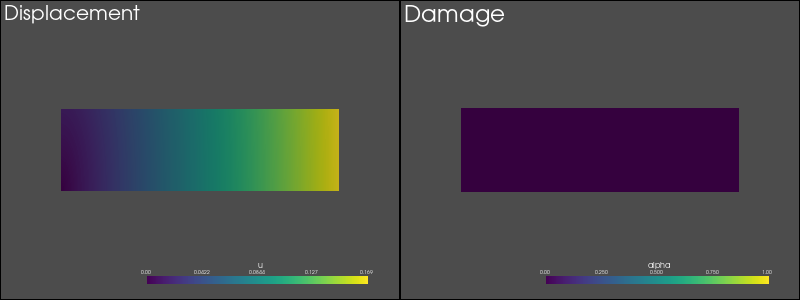

-- Solving for t = 0.18 --
Iteration:   0, Error: 0.0000e+00


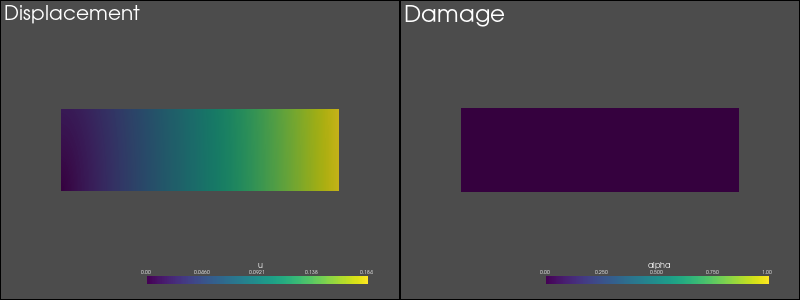

-- Solving for t = 0.20 --
Iteration:   0, Error: 2.1272e-02
Iteration:   1, Error: 1.0410e-02
Iteration:   2, Error: 1.3868e-02
Iteration:   3, Error: 1.9660e-02
Iteration:   4, Error: 2.6020e-02
Iteration:   5, Error: 3.2634e-02
Iteration:   6, Error: 3.7545e-02
Iteration:   7, Error: 3.6467e-02
Iteration:   8, Error: 2.7822e-02
Iteration:   9, Error: 2.8471e-02
Iteration:  10, Error: 2.6135e-02
Iteration:  11, Error: 6.8805e-03
Iteration:  12, Error: 6.7330e-03
Iteration:  13, Error: 4.1048e-03
Iteration:  14, Error: 1.0069e-03
Iteration:  15, Error: 2.7417e-04
Iteration:  16, Error: 1.0177e-04
Iteration:  17, Error: 2.6176e-05
Iteration:  18, Error: 6.1540e-06
Iteration:  19, Error: 1.4352e-06
Iteration:  20, Error: 3.3461e-07


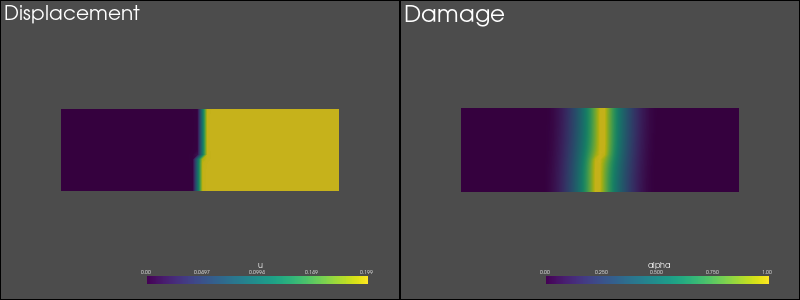

-- Solving for t = 0.21 --
Iteration:   0, Error: 2.1993e-04
Iteration:   1, Error: 1.1540e-05
Iteration:   2, Error: 1.9346e-06
Iteration:   3, Error: 3.4096e-07


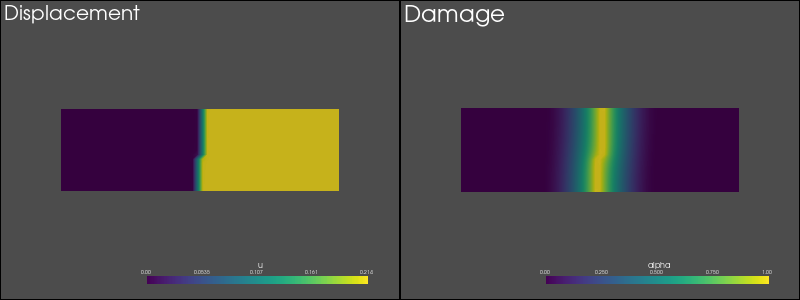

-- Solving for t = 0.23 --
Iteration:   0, Error: 1.7663e-04
Iteration:   1, Error: 7.8292e-06
Iteration:   2, Error: 1.0810e-06
Iteration:   3, Error: 1.5698e-07


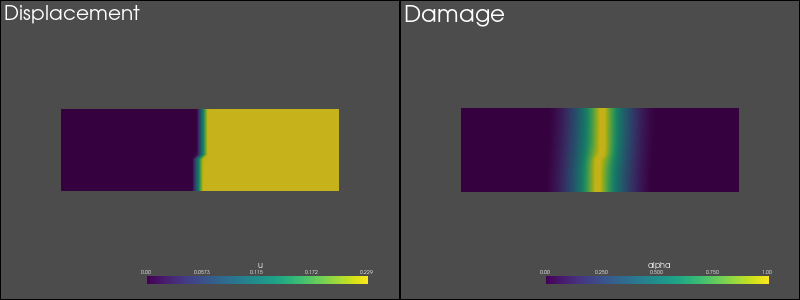

-- Solving for t = 0.24 --
Iteration:   0, Error: 1.4436e-04
Iteration:   1, Error: 5.3929e-06
Iteration:   2, Error: 6.1581e-07


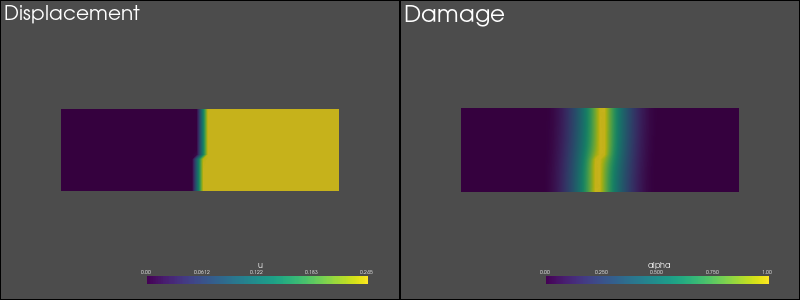

-- Solving for t = 0.26 --
Iteration:   0, Error: 1.1961e-04
Iteration:   1, Error: 3.7868e-06
Iteration:   2, Error: 3.5947e-07


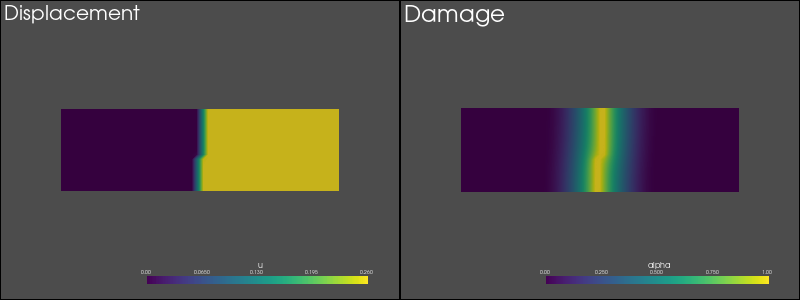

-- Solving for t = 0.28 --
Iteration:   0, Error: 1.0027e-04
Iteration:   1, Error: 2.6940e-06
Iteration:   2, Error: 2.1381e-07


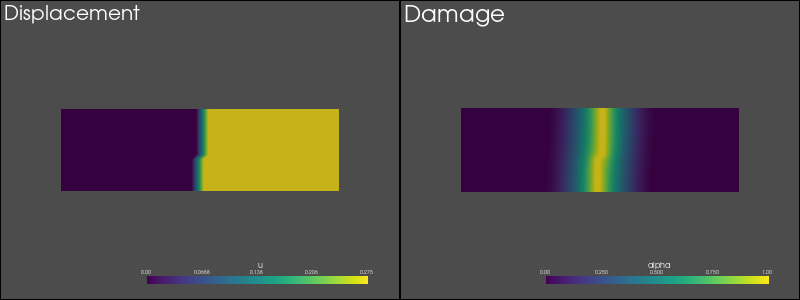

-- Solving for t = 0.29 --
Iteration:   0, Error: 8.4945e-05
Iteration:   1, Error: 1.9469e-06
Iteration:   2, Error: 1.2991e-07


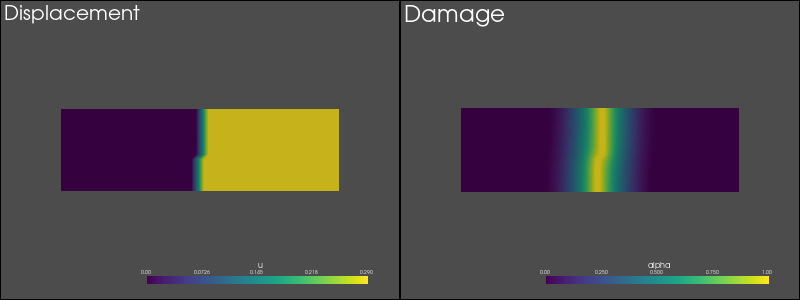

In [19]:
load0 = float(eps_c)*L # reference value for the loading (imposed displacement)
loads = load0*np.linspace(0,1.5,20)

energies = np.zeros((len(loads),4))
iterations = np.zeros((len(loads),2))

alt_min_parameters = {"atol": 1.e-6,"max_iter": 100}

with alpha.vector.localForm() as alpha_local:
    alpha_local.set(0)

for i_t, t in enumerate(loads):
    u_D.value = t
        
    # update the lower bound
    alpha.vector.copy(alpha_lb.vector)    
    print(f"-- Solving for t = {t:3.2f} --")
    alternate_minimization(state,parameters=alt_min_parameters,monitor=postprocessing)
    plot_damage_state(state)

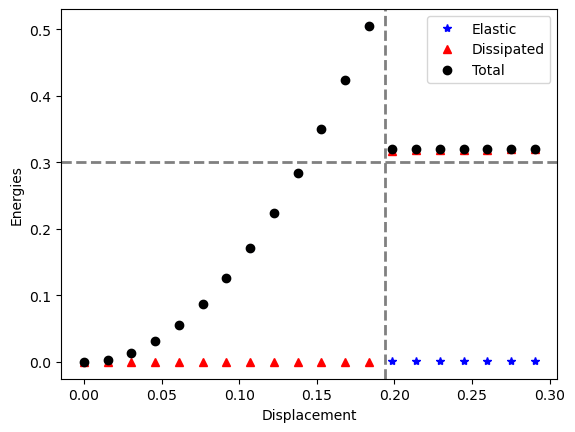

In [20]:
p1, = plt.plot(energies[:,0], energies[:,1],'b*',linewidth=2)
p2, = plt.plot(energies[:,0], energies[:,2],'r^',linewidth=2)
p3, = plt.plot(energies[:,0], energies[:,3],'ko',linewidth=2)
plt.legend([p1, p2, p3], ["Elastic","Dissipated","Total"])
plt.xlabel('Displacement')
plt.ylabel('Energies')

plt.axvline(x=eps_c*L, color='grey',linestyle='--', linewidth=2)
plt.axhline(y=H, color='grey', linestyle='--', linewidth=2)

plt.savefig(f"output/energies.png")

## Verification

The plots above indicates that the crack appear at the elastic limit calculated analytically (see the gridlines) and that the dissipated energy coincide with the length of the crack times $G_c$. Let's check the latter explicity

In [21]:
surface_energy_value = comm.allreduce(dolfinx.fem.assemble_scalar(dolfinx.fem.form(dissipated_energy)),
            op=MPI.SUM)
print(f"The dissipated energy on a crack is {surface_energy_value:.3f}")
print(f"The expected value is {H:f}")

The dissipated energy on a crack is 0.319
The expected value is 0.300000


Let us look at the damage profile

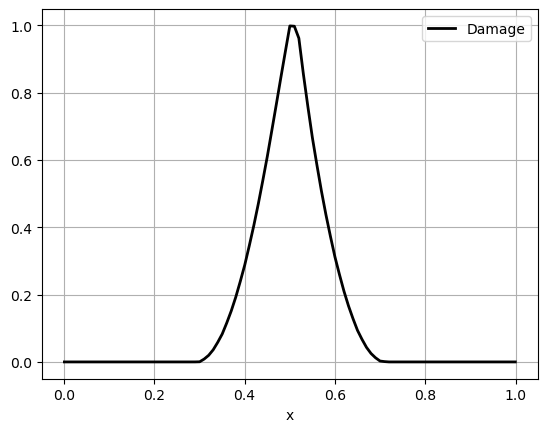

In [24]:
from evaluate_on_points import evaluate_on_points
tol = 0.001 # Avoid hitting the outside of the domain
y = np.linspace(0 + tol, L - tol, 101)
points = np.zeros((3, 101))
points[0] = y
points[1] = H/2


fig = plt.figure()
points_on_proc, alpha_val = evaluate_on_points(alpha, points)
plt.plot(points_on_proc[:,0], alpha_val, "k", linewidth=2, label="Damage")
plt.grid(True)
plt.xlabel("x")
plt.legend()

# If run in parallel as a python file, we save a plot per processor
plt.savefig(f"output/damage_line_rank{MPI.COMM_WORLD.rank:d}.png")

## Exercises

- Replace the mesh with an unstructured mesh generated with gmsh
- Refactor `alternate_minimization` as an external function or class to put in a seperate `.py` file to import in the notebook
- Run simulations for
    1. A slab with an hole in the center
    2. A slab with a V-notch